# viral gene expression
This notebook looks at viral gene expression

## Notebook setup
First give paths and values to all variables. Then, load in data.

Python imports:

In [59]:
from IPython.display import display

from dms_variants.constants import CBPALETTE

import numpy

import pandas as pd

import plotnine as p9

import scanpy

import scipy

import statsmodels.stats.multitest

import subprocess

Input data paths. Currently hardcoded.

In [29]:
matrix = 'results/aligned_fastq10x/scProgenyProduction_trial3/Solo.out/GeneFull/filtered/matrix.mtx'
cell_barcodes = 'results/aligned_fastq10x/scProgenyProduction_trial3/Solo.out/GeneFull/filtered/barcodes.tsv'
features = 'results/aligned_fastq10x/scProgenyProduction_trial3/Solo.out/GeneFull/filtered/features.tsv'
viral_tag_by_cell_csv = 'results/viral_tags_bcs_in_cells/scProgenyProduction_trial3_cell_barcodes_with_viral_tags.csv.gz'
viral_bc_background_freq_csv = 'results/viral_fastq10x/scProgenyProduction_trial3_viral_bc_background_freq.csv.gz'
viral_bc_in_progeny_freq_csv = 'results/viral_progeny/scProgenyProduction_trial3_viral_bc_in_progeny_freq.csv.gz'

Global variables for this notebook:

In [30]:
expt = 'scProgenyProduction_trial3'
plot = 'results/viral_fastq10x/scProgenyProduction_trial3_viral_bc_correlations.pdf'
viral_genes = ['fluPB2', 'fluPB1', 'fluPA', 'fluHA', 'fluNA', 'fluNP', 'fluM', 'fluNS']
barcoded_viral_genes = ['fluHA', 'fluNA']

Style parameters. *N.b.* `CBPALETTE` is defined in imports above.

In [31]:
p9.theme_set(p9.theme_classic())

### Load data

**Transcriptome** viral barcode frequencies:

In [32]:
transcriptome_viral_bc_freqs = pd.read_csv(viral_bc_background_freq_csv)
assert set(transcriptome_viral_bc_freqs['gene']) == set(barcoded_viral_genes), \
       "Barcoded genes in barcode counts do not match expectation."
display(transcriptome_viral_bc_freqs)

,cell_barcode,infected,infecting_viral_tag,gene,viral_barcode,frac_viral_bc_UMIs,reject_uninfected
0,AAACGAAAGCCACCGT,True,wt,fluHA,AATTAGAAAGCACGGT,0.000024,False
1,AAACGAAAGCCACCGT,True,wt,fluHA,GACCGAACTCGAAGCG,0.000982,True
2,AAACGAAAGCCACCGT,True,wt,fluHA,GACCTAACTCGAAGCT,0.000024,False
3,AAACGCTAGTTCACTG,True,syn,fluHA,AAGAAAAAAATAATCA,0.000086,False
4,AAACGCTAGTTCACTG,True,syn,fluHA,AGGAAAGTAAATTAAG,0.000086,False
...,...,...,...,...,...,...,...
9202,TTTGTTGTCGGAATGG,True,wt,fluNA,ATGAGTTCACGGGGGT,0.000670,True
9203,TTTGTTGTCGGAATGG,True,wt,fluNA,CAACAGGGAGTAAGGT,0.001191,True
9204,TTTGTTGTCGGAATGG,True,wt,fluNA,GAATAAACAGGGGGGA,0.000074,False
9205,TTTGTTGTCGGAATGG,True,wt,fluNA,GATTATACCGGAGGGA,0.000074,False


Cell-gene matrix:

In [33]:
adata = scanpy.read_mtx(matrix)
adata.var = pd.read_csv(cell_barcodes,
                        names=['cell_barcode'])
adata.obs = pd.read_csv(features,
                        sep='\t',
                        names=['ensemble_id', 'gene', 'feature_type'])

print(f"Read cell-gene matrix of {adata.n_vars} cells and {adata.n_obs} genes")

assert set(viral_genes).issubset(set(adata.obs['gene'])), 'lack viral genes'

Read cell-gene matrix of 1399 cells and 30959 genes


### Cross-check data
Use assert statements to ensure that that the number and identity of cell barcodes is identical between data sources.

In [34]:
assert transcriptome_viral_bc_freqs['cell_barcode'].nunique() == \
       adata.var['cell_barcode'].nunique(), \
       "Number of cells discrepancy"

assert set(transcriptome_viral_bc_freqs['cell_barcode']) == \
       set(adata.var['cell_barcode']), \
       "Cell barcodes do not match between data sources"

### Plot raw data
Plot data from each source without filtering or processing. This is mostly for exploration and transparency.

#### Viral barcode transcription

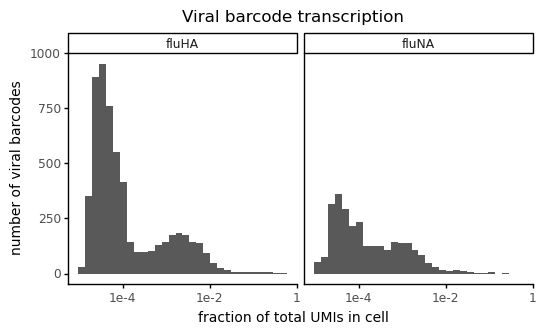

<ggplot: (8728051628960)>

In [36]:
fig = (p9.ggplot((transcriptome_viral_bc_freqs
                  .query('viral_barcode.notnull()',
                         engine='python')),
                 p9.aes(x='frac_viral_bc_UMIs')) +
       p9.geom_histogram(bins=30) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'Viral barcode transcription') +
       p9.labs(x='fraction of total UMIs in cell',
               y='number of viral barcodes') +
       p9.scale_x_log10() +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

### Process data
Next, I will merge the data into a few useable dataframes. I will perform calculations on these data that will help us visualize technical error and filter.

#### Viral genes in each cell
Extract the UMI counts for each viral gene in each cell from `adata.obs`

In [37]:
#### Viral genes in each cell
viral_gene_expression = (
    adata.var
    .assign(total_UMIs=numpy.sum(adata.X, axis=0).A1.astype(int),
            viral_UMIs=numpy.sum(adata[adata.obs['gene']
                                   .isin(viral_genes), ].X,
                                 axis=0).A1.astype(int),
            fluPB2=numpy.sum(adata[adata.obs['gene'] == 'fluPB2', ]
                             .X, axis=0).A1.astype(int),
            fluPB1=numpy.sum(adata[adata.obs['gene'] == 'fluPB1', ]
                             .X, axis=0).A1.astype(int),
            fluPA=numpy.sum(adata[adata.obs['gene'] == 'fluPA', ]
                             .X, axis=0).A1.astype(int),
            fluHA=numpy.sum(adata[adata.obs['gene'] == 'fluHA', ]
                             .X, axis=0).A1.astype(int),
            fluNP=numpy.sum(adata[adata.obs['gene'] == 'fluNP', ]
                             .X, axis=0).A1.astype(int),
            fluNA=numpy.sum(adata[adata.obs['gene'] == 'fluNA', ]
                             .X, axis=0).A1.astype(int),
            fluM=numpy.sum(adata[adata.obs['gene'] == 'fluM', ]
                             .X, axis=0).A1.astype(int),
            fluNS=numpy.sum(adata[adata.obs['gene'] == 'fluNS', ]
                             .X, axis=0).A1.astype(int),
           )
)

viral_gene_expression

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


,cell_barcode,total_UMIs,viral_UMIs,fluPB2,fluPB1,fluPA,fluHA,fluNP,fluNA,fluM,fluNS
0,AAACGAAAGCCACCGT,41743,451,0,25,5,101,5,26,54,235
1,AAACGCTAGTTCACTG,11572,4702,3,52,0,650,501,101,2075,1320
2,AAACGCTTCTCATTAC,5159,793,2,20,3,539,61,2,95,71
3,AAAGAACAGAGAGCAA,41059,13,0,0,0,1,1,1,5,5
4,AAAGAACGTAATTGGA,24525,3948,19,60,4,456,37,0,1340,2032
...,...,...,...,...,...,...,...,...,...,...,...
1394,TTTGGAGGTTGTATGC,24104,17946,507,212,321,2895,5898,1,8111,1
1395,TTTGGTTAGCAAGTCG,21155,66,6,1,1,4,9,2,5,38
1396,TTTGTTGGTATTCCTT,20621,27,1,0,0,5,3,1,10,7
1397,TTTGTTGGTGGTGATG,29335,2398,7,24,6,194,191,182,767,1027


Bring in infection status and tag information:

In [38]:
viral_gene_expression = pd.merge(
    left=viral_gene_expression,
    right=(transcriptome_viral_bc_freqs
           .query('cell_barcode.notnull()',
                  engine='python')
           [['cell_barcode',
             'infected',
             'infecting_viral_tag']]
           .drop_duplicates()),
    on='cell_barcode',
    how='left',
    validate='one_to_one'
    )

viral_gene_expression

,cell_barcode,total_UMIs,viral_UMIs,fluPB2,fluPB1,fluPA,fluHA,fluNP,fluNA,fluM,fluNS,infected,infecting_viral_tag
0,AAACGAAAGCCACCGT,41743,451,0,25,5,101,5,26,54,235,True,wt
1,AAACGCTAGTTCACTG,11572,4702,3,52,0,650,501,101,2075,1320,True,syn
2,AAACGCTTCTCATTAC,5159,793,2,20,3,539,61,2,95,71,True,both
3,AAAGAACAGAGAGCAA,41059,13,0,0,0,1,1,1,5,5,False,none
4,AAAGAACGTAATTGGA,24525,3948,19,60,4,456,37,0,1340,2032,True,syn
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1394,TTTGGAGGTTGTATGC,24104,17946,507,212,321,2895,5898,1,8111,1,True,wt
1395,TTTGGTTAGCAAGTCG,21155,66,6,1,1,4,9,2,5,38,True,syn
1396,TTTGTTGGTATTCCTT,20621,27,1,0,0,5,3,1,10,7,False,none
1397,TTTGTTGGTGGTGATG,29335,2398,7,24,6,194,191,182,767,1027,True,wt


Pivot the table so that gene is a column, and the UMI counts for each gene for each cell is a row

In [39]:
viral_gene_expression_long = viral_gene_expression.melt(
    id_vars=['cell_barcode',
             'infected',
             'infecting_viral_tag',
             'total_UMIs',
             'viral_UMIs'],
    var_name='gene',
    value_name='gene_UMIs'
)

viral_gene_expression_long

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,gene,gene_UMIs
0,AAACGAAAGCCACCGT,True,wt,41743,451,fluPB2,0
1,AAACGCTAGTTCACTG,True,syn,11572,4702,fluPB2,3
2,AAACGCTTCTCATTAC,True,both,5159,793,fluPB2,2
3,AAAGAACAGAGAGCAA,False,none,41059,13,fluPB2,0
4,AAAGAACGTAATTGGA,True,syn,24525,3948,fluPB2,19
...,...,...,...,...,...,...,...
11187,TTTGGAGGTTGTATGC,True,wt,24104,17946,fluNS,1
11188,TTTGGTTAGCAAGTCG,True,syn,21155,66,fluNS,38
11189,TTTGTTGGTATTCCTT,False,none,20621,27,fluNS,7
11190,TTTGTTGGTGGTGATG,True,wt,29335,2398,fluNS,1027


Check that total number of rows is = total number of cells * total number of genes, for both infected and uninfected:

In [40]:
assert (len(viral_gene_expression_long) ==
        len(viral_gene_expression_long['cell_barcode'].drop_duplicates()) *
        len(viral_genes)), "not 8 genes for every cell"

Check that the extracted gene_UMIs sum to the total viral UMIs for each cell:

In [41]:
pd.testing.assert_frame_equal(
    (viral_gene_expression_long[['cell_barcode',
                                 'viral_UMIs']]
     .drop_duplicates()),
    (viral_gene_expression_long
     .groupby('cell_barcode')
     ['gene_UMIs']
     .sum()
     .to_frame()
     .reset_index()
     .rename(columns={'gene_UMIs': 'viral_UMIs'})),
    check_names=False,
    check_index_type=False
)

Calculate the fraction of all UMIs assigned to each viral gene individually, and in aggregate:

In [42]:
viral_gene_expression_long['frac_viral_UMIs'] = (
    viral_gene_expression_long['viral_UMIs'] /
    viral_gene_expression_long['total_UMIs'])

viral_gene_expression_long['frac_gene_UMIs'] = (
    viral_gene_expression_long['gene_UMIs'] /
    viral_gene_expression_long['total_UMIs'])

viral_gene_expression_long

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,gene,gene_UMIs,frac_viral_UMIs,frac_gene_UMIs
0,AAACGAAAGCCACCGT,True,wt,41743,451,fluPB2,0,0.010804,0.000000
1,AAACGCTAGTTCACTG,True,syn,11572,4702,fluPB2,3,0.406326,0.000259
2,AAACGCTTCTCATTAC,True,both,5159,793,fluPB2,2,0.153712,0.000388
3,AAAGAACAGAGAGCAA,False,none,41059,13,fluPB2,0,0.000317,0.000000
4,AAAGAACGTAATTGGA,True,syn,24525,3948,fluPB2,19,0.160979,0.000775
...,...,...,...,...,...,...,...,...,...
11187,TTTGGAGGTTGTATGC,True,wt,24104,17946,fluNS,1,0.744524,0.000041
11188,TTTGGTTAGCAAGTCG,True,syn,21155,66,fluNS,38,0.003120,0.001796
11189,TTTGTTGGTATTCCTT,False,none,20621,27,fluNS,7,0.001309,0.000339
11190,TTTGTTGGTGGTGATG,True,wt,29335,2398,fluNS,1027,0.081745,0.035009


Plot distribution of absolute UMI counts for each gene:

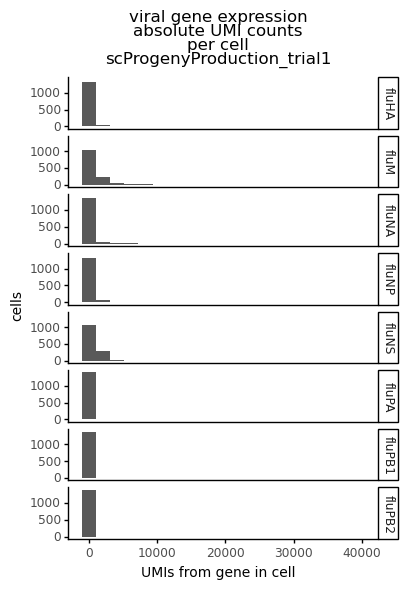

<ggplot: (8728066814787)>

In [43]:
fig = (p9.ggplot(viral_gene_expression_long,
                 p9.aes(x='gene_UMIs')) +
       p9.geom_histogram(bins=20) +
       p9.facet_grid('gene~') +
       p9.ggtitle('viral gene expression\n'
                  'absolute UMI counts\n'
                  'per cell\n'
                  f'{expt}') +
       p9.labs(x='UMIs from gene in cell',
               y='cells') +
       p9.theme(figure_size=(4, 6),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

Plot on log scale:

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_bin : Removed 2080 rows containing non-finite values.


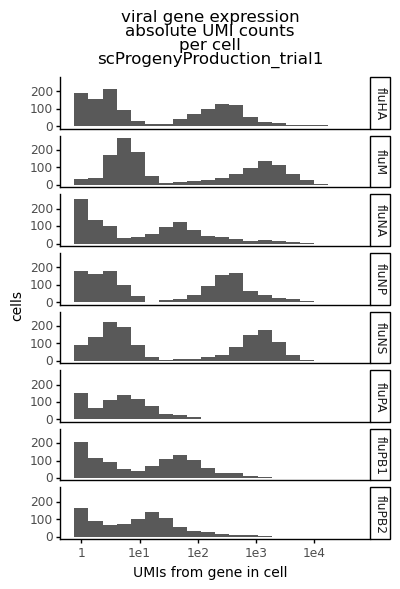

<ggplot: (8728051563611)>

In [44]:
fig = (p9.ggplot(viral_gene_expression_long,
                 p9.aes(x='gene_UMIs')) +
       p9.geom_histogram(bins=20) +
       p9.facet_grid('gene~') +
       p9.ggtitle('viral gene expression\n'
                  'absolute UMI counts\n'
                  'per cell\n'
                  f'{expt}') +
       p9.labs(x='UMIs from gene in cell',
               y='cells') +
       p9.scale_x_log10() +
       p9.theme(figure_size=(4, 6),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

Plot distribution of fraction of UMIs from each viral gene:

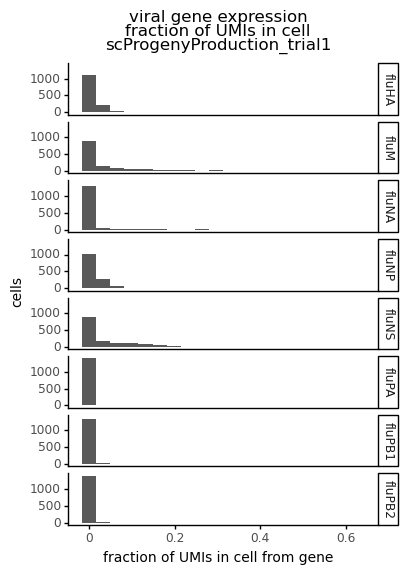

<ggplot: (8728727525241)>

In [45]:
fig = (p9.ggplot(viral_gene_expression_long,
                 p9.aes(x='frac_gene_UMIs')) +
       p9.geom_histogram(bins=20) +
       p9.facet_grid('gene~') +
       p9.ggtitle('viral gene expression\n'
                  'fraction of UMIs in cell\n'
                  f'{expt}') +
       p9.labs(x='fraction of UMIs in cell from gene',
               y='cells') +
       p9.theme(figure_size=(4, 6),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

Plot on log scale:

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_bin : Removed 2080 rows containing non-finite values.


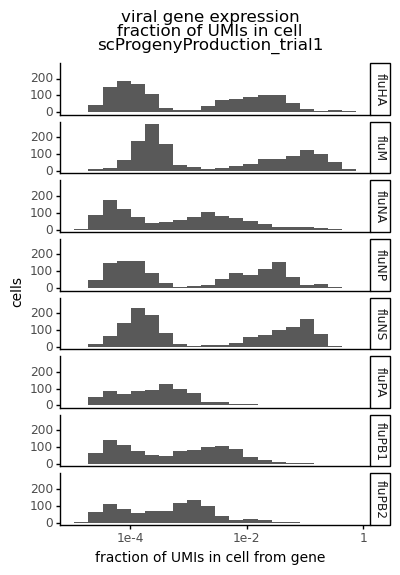

<ggplot: (8728728101024)>

In [46]:
fig = (p9.ggplot(viral_gene_expression_long,
                 p9.aes(x='frac_gene_UMIs')) +
       p9.geom_histogram(bins=20) +
       p9.facet_grid('gene~') +
       p9.ggtitle('viral gene expression\n'
                  'fraction of UMIs in cell\n'
                  f'{expt}') +
       p9.labs(x='fraction of UMIs in cell from gene',
               y='cells') +
       p9.scale_x_log10() +
       p9.theme(figure_size=(4, 6),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

What is the relationship between absolute UMI counts and fraction of all UMIs in cell for each gene?

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


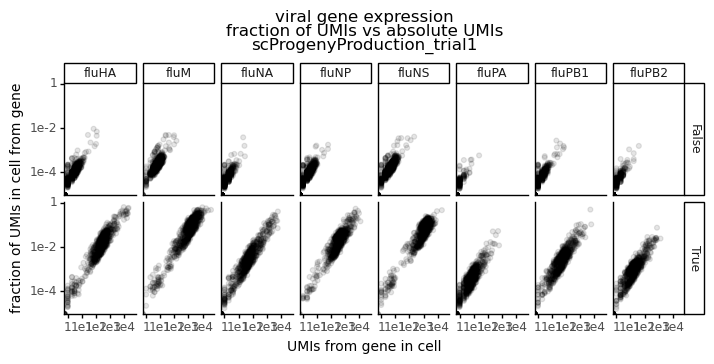

<ggplot: (8728065744595)>

In [47]:
fig = (p9.ggplot(viral_gene_expression_long,
                 p9.aes(x='gene_UMIs',
                        y='frac_gene_UMIs')) +
       p9.geom_point(alpha=0.1) +
       p9.facet_grid('infected~gene') +
       p9.ggtitle('viral gene expression\n'
                  'fraction of UMIs vs absolute UMIs\n'
                  f'{expt}') +
       p9.labs(x='UMIs from gene in cell',
               y='fraction of UMIs in cell from gene') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.theme(figure_size=(8, 3),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

Distribution of viral gene expression in infected and **uninfected** cells:

**N.b.** Plot 0 values on far left of axis, 100-fold lower than lowest real value:

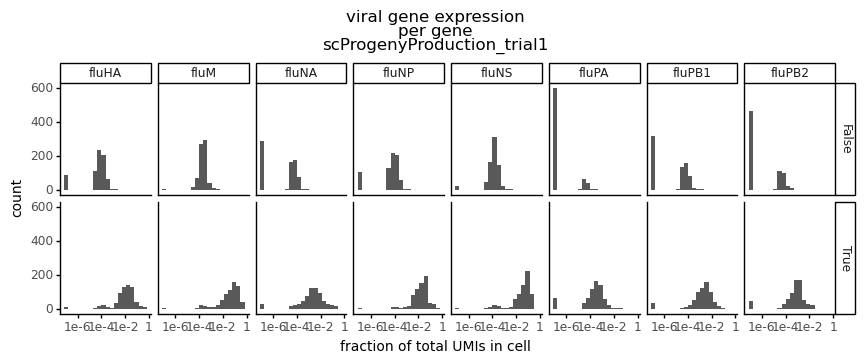

<ggplot: (8728067270271)>

In [48]:
zero_pseudocount = (min(viral_gene_expression_long
                        .query('frac_gene_UMIs > 0')
                        ['frac_gene_UMIs']) /
                    100)
zero_pseudocount

fig = (p9.ggplot((viral_gene_expression_long
                  .replace(to_replace={'frac_gene_UMIs':0},
                           value=zero_pseudocount)),
                 p9.aes(x='frac_gene_UMIs')) +
       p9.geom_histogram(bins=20) +
       p9.facet_grid('infected~gene') +
       p9.ggtitle(f'viral gene expression\n'
                  f'per gene\n'
                  f'{expt}') +
       p9.labs(x='fraction of total UMIs in cell') +
       p9.theme(figure_size=(10, 3),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center') +
       p9.scale_x_log10())
display(fig)

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_boxplot : Removed 2080 rows containing non-finite values.


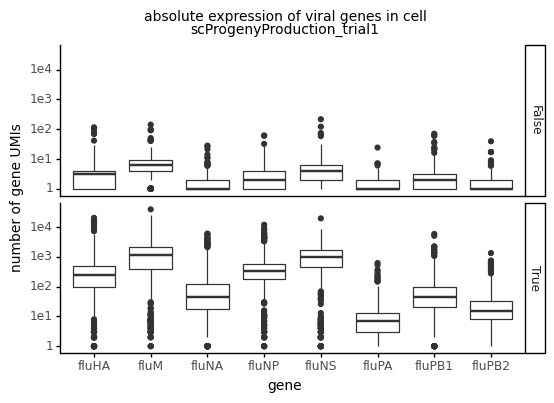

<ggplot: (8728067474261)>

In [95]:
fig = (p9.ggplot((viral_gene_expression_long),
                  p9.aes(x='factor(gene)',
                         y='gene_UMIs')) +
              p9.geom_boxplot() +
              p9.facet_grid('infected~') +
              p9.ggtitle('absolute expression of viral genes in cell\n'
                         f'{expt}') +
              p9.xlab('gene') +
              p9.ylab('number of gene UMIs') +
              p9.scale_y_log10() +
              p9.theme(figure_size=(6, 4),
                       plot_title=p9.element_text(size=10),
                       axis_title=p9.element_text(size=10),
                       legend_title=p9.element_text(size=9),
                       legend_title_align='center') +
              p9.scale_x_discrete())
display(fig)

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_boxplot : Removed 2080 rows containing non-finite values.


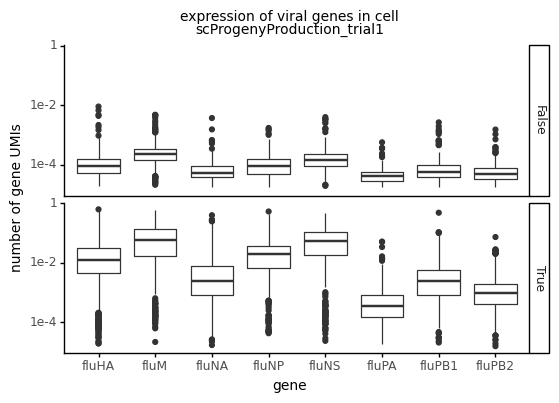

<ggplot: (8728726827334)>

In [94]:
fig = (p9.ggplot((viral_gene_expression_long),
                  p9.aes(x='factor(gene)',
                         y='frac_gene_UMIs')) +
              p9.geom_boxplot() +
              p9.facet_grid('infected~') +
              p9.ggtitle('expression of viral genes in cell\n'
                         f'{expt}') +
              p9.xlab('gene') +
              p9.ylab('number of gene UMIs') +
              p9.scale_y_log10() +
              p9.theme(figure_size=(6, 4),
                       plot_title=p9.element_text(size=10),
                       axis_title=p9.element_text(size=10),
                       legend_title=p9.element_text(size=9),
                       legend_title_align='center') +
              p9.scale_x_discrete())
display(fig)

#### Proportion of viral UMIs from each gene

Next, within each cell, I will calculate the proportion of all viral UMIs derived from each gene. 

In [51]:
viral_gene_expression_long['prop_viral_UMIs'] = (
    viral_gene_expression_long['gene_UMIs'] /
    viral_gene_expression_long['viral_UMIs']
)

viral_gene_expression_long

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,gene,gene_UMIs,frac_viral_UMIs,frac_gene_UMIs,prop_viral_UMIs
0,AAACGAAAGCCACCGT,True,wt,41743,451,fluPB2,0,0.010804,0.000000,0.000000
1,AAACGCTAGTTCACTG,True,syn,11572,4702,fluPB2,3,0.406326,0.000259,0.000638
2,AAACGCTTCTCATTAC,True,both,5159,793,fluPB2,2,0.153712,0.000388,0.002522
3,AAAGAACAGAGAGCAA,False,none,41059,13,fluPB2,0,0.000317,0.000000,0.000000
4,AAAGAACGTAATTGGA,True,syn,24525,3948,fluPB2,19,0.160979,0.000775,0.004813
...,...,...,...,...,...,...,...,...,...,...
11187,TTTGGAGGTTGTATGC,True,wt,24104,17946,fluNS,1,0.744524,0.000041,0.000056
11188,TTTGGTTAGCAAGTCG,True,syn,21155,66,fluNS,38,0.003120,0.001796,0.575758
11189,TTTGTTGGTATTCCTT,False,none,20621,27,fluNS,7,0.001309,0.000339,0.259259
11190,TTTGTTGGTGGTGATG,True,wt,29335,2398,fluNS,1027,0.081745,0.035009,0.428274


Check that the proportion sums to 1 for every cell:

In [52]:
test_prop_sum_df = pd.merge(
    left=viral_gene_expression_long,
    right=(viral_gene_expression_long
           .groupby('cell_barcode')
           ['prop_viral_UMIs']
           .sum()
           .round(4)),
    suffixes=[None,'_sum'],
    on='cell_barcode',
)

test_prop_sum_df['sum_OK'] = test_prop_sum_df.apply(
    lambda x: (x['prop_viral_UMIs_sum'] == 1) or (x['viral_UMIs'] == 0),
    axis=1)
                              
assert (test_prop_sum_df['sum_OK'] == True).all(), \
    "problem summing viral gene proportions"

test_prop_sum_df


,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,gene,gene_UMIs,frac_viral_UMIs,frac_gene_UMIs,prop_viral_UMIs,prop_viral_UMIs_sum,sum_OK
0,AAACGAAAGCCACCGT,True,wt,41743,451,fluPB2,0,0.010804,0.000000,0.000000,1.0,True
1,AAACGAAAGCCACCGT,True,wt,41743,451,fluPB1,25,0.010804,0.000599,0.055432,1.0,True
2,AAACGAAAGCCACCGT,True,wt,41743,451,fluPA,5,0.010804,0.000120,0.011086,1.0,True
3,AAACGAAAGCCACCGT,True,wt,41743,451,fluHA,101,0.010804,0.002420,0.223947,1.0,True
4,AAACGAAAGCCACCGT,True,wt,41743,451,fluNP,5,0.010804,0.000120,0.011086,1.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...
11187,TTTGTTGTCGGAATGG,True,wt,13433,5142,fluHA,460,0.382789,0.034244,0.089459,1.0,True
11188,TTTGTTGTCGGAATGG,True,wt,13433,5142,fluNP,405,0.382789,0.030150,0.078763,1.0,True
11189,TTTGTTGTCGGAATGG,True,wt,13433,5142,fluNA,59,0.382789,0.004392,0.011474,1.0,True
11190,TTTGTTGTCGGAATGG,True,wt,13433,5142,fluM,2784,0.382789,0.207251,0.541424,1.0,True


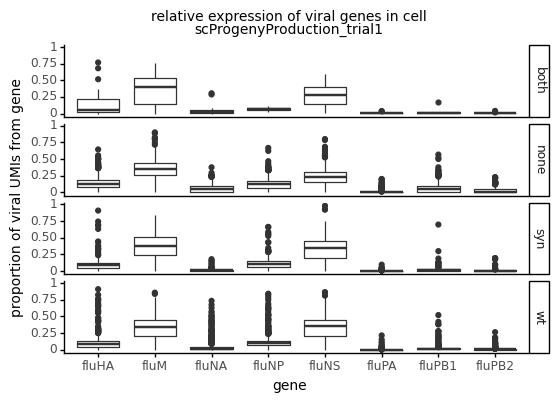

<ggplot: (8728067611227)>

In [96]:
fig = (p9.ggplot((viral_gene_expression_long),
                  p9.aes(x='factor(gene)',
                         y='prop_viral_UMIs')) +
              p9.geom_boxplot() +
              p9.ggtitle('relative expression of viral genes in cell\n'
                         f'{expt}') +
              p9.facet_grid('infecting_viral_tag~') +
              p9.xlab('gene') +
              p9.ylab('proportion of viral UMIs from gene') +
              p9.theme(figure_size=(6, 4),
                       plot_title=p9.element_text(size=10),
                       axis_title=p9.element_text(size=10),
                       legend_title=p9.element_text(size=9),
                       legend_title_align='center') +
              p9.scale_x_discrete())
display(fig)

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


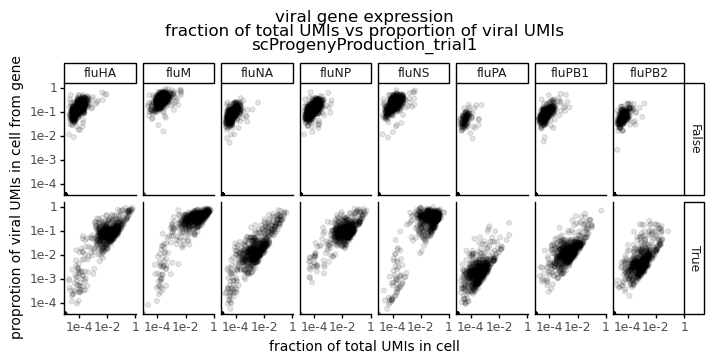

<ggplot: (8728051457600)>

In [54]:
fig = (p9.ggplot(viral_gene_expression_long,
                 p9.aes(x='frac_gene_UMIs',
                        y='prop_viral_UMIs')) +
       p9.geom_point(alpha=0.1) +
       p9.facet_grid('infected~gene') +
       p9.ggtitle('viral gene expression\n'
                  'fraction of total UMIs vs proportion of viral UMIs\n'
                  f'{expt}') +
       p9.labs(x='fraction of total UMIs in cell',
               y='proprotion of viral UMIs in cell from gene') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.theme(figure_size=(8, 3),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

## Bulk viral gene expression
First, simply look at the read counts assigned to each viral gene in the BAM file.

In [55]:
bam_file = 'results/aligned_fastq10x/' + expt + '/Aligned.sortedByCoord.out.bam'

In [56]:
bam_file

'results/aligned_fastq10x/scProgenyProduction_trial1/Aligned.sortedByCoord.out.bam'

In [75]:
cmd = ['samtools',
       'idxstats',
       bam_file]

with open('tmp.tsv', 'w') as f:
    subprocess.check_call(cmd, stdout=f)

with open('tmp.tsv', 'r') as f:
    bulk_gex = pd.read_csv(f, sep='\t', header=None)
    bulk_gex.rename(columns={0:'ref_id',
                             1:'contig_len',
                             2:'mapped_reads',
                             3:'unmapped_reads'},
                    inplace=True)

bulk_gex

,ref_id,contig_len,mapped_reads,unmapped_reads
0,1,122678785,4336675,0
1,2,85426708,2776036,0
2,3,91889043,2044908,0
3,4,88276631,1838832,0
4,5,88915250,2818816,0
...,...,...,...,...
3272,fluNP,1565,610268,0
3273,fluNA,1735,232430,0
3274,fluM,1027,1882239,0
3275,fluNS,890,1313973,0


In [80]:
bulk_gex.query(f'ref_id in {viral_genes}')

,ref_id,contig_len,mapped_reads,unmapped_reads
3268,fluPB2,2341,44296,0
3269,fluPB1,2341,128179,0
3270,fluPA,2233,15331,0
3271,fluHA,2035,731479,0
3272,fluNP,1565,610268,0
3273,fluNA,1735,232430,0
3274,fluM,1027,1882239,0
3275,fluNS,890,1313973,0


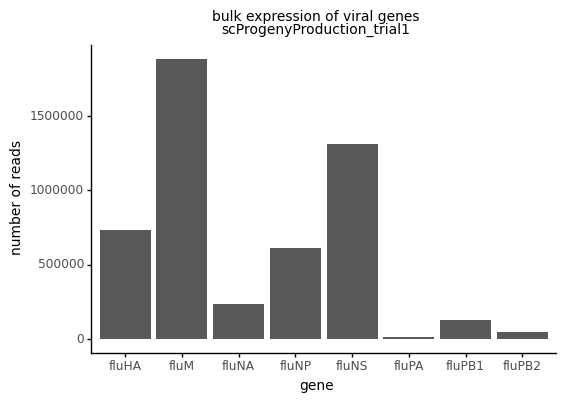

<ggplot: (8728067581850)>

In [98]:
fig = (p9.ggplot((bulk_gex.query(f'ref_id in {viral_genes}')),
                  p9.aes(x='factor(ref_id)',
                         y='mapped_reads')) +
              p9.geom_bar(stat='identity') +
              p9.ggtitle('bulk expression of viral genes\n'
                         f'{expt}') +
              p9.xlab('gene') +
              p9.ylab('number of reads') +
              p9.theme(figure_size=(6, 4),
                       plot_title=p9.element_text(size=10),
                       axis_title=p9.element_text(size=10),
                       legend_title=p9.element_text(size=9),
                       legend_title_align='center') +
              p9.scale_x_discrete())
display(fig)